In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt

In [19]:
# Function to load the dataset
def load_dataset(dataset_name=None):
    return pd.read_csv(f'data/{dataset_name}')

In [20]:
data = load_dataset('features_3_sec.csv')

In [21]:
train, test = train_test_split(data, test_size=0.2, random_state=42, stratify=data['label'])

### *Getting The Train Set And Test Set

- This code separates the data into features (inputs) and labels (targets) for both training and testing. It also removes the `'filename'` column because it's not relevant for model training.

In [22]:
X = train.drop(columns=['label'])
y = train['label']

X_test = test.drop(columns=['label'])
y_test = test['label']

X = X.drop(columns=['filename'])

X_test = X_test.drop(columns=['filename'])

### *Grid Search*

Takes 26 minutes to run on Cole's desktop <br>
Best found params just in case: `{'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 100}`

In [23]:
params = {
    'n_estimators': [10, 25, 50, 100],
    'learning_rate': [0.1, 0.3, 0.5],
    'max_depth': [1, 2, 3, 4]
}

gbc = GradientBoostingClassifier()

gs = GridSearchCV(gbc, param_grid=params, cv=5, n_jobs=-1, scoring='recall_macro')

gs.fit(X, y)

gs.predict(X_test)

print(gs.best_params_)
print(gs.best_score_)

report = classification_report(y_test, gs.predict(X_test))
print(report)

### *Correlation Matrix Of The Model vs Actual Values*

- So we can see in the diagonal values, which show correct predictions, and any significant misclassifications off the diagonal. Focus on where the model confuses similar genres to understand its weaknesses and areas for improvement.


#### **Pop vs Disco**
- The model predicted disco 12 times when the actual genre was pop. Conversely, it predicted pop 6 times when the actual genre was disco. This suggests the model has difficulty distinguishing between pop and disco, likely due to shared audio features like rhythm or tempo.

#### **Rock vs Country**
- The model predicted country 13 times when the actual genre was rock. Conversely, it predicted rock 9 times when the actual genre was country. This indicates the model frequently confuses rock with country, potentially due to similarities in guitar sounds, rhythms, or tempos common to both genres.

In [17]:
# graphing the decision, what the model predicted vs that actual value
cm = confusion_matrix(y_test, gs.predict(X_test))
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, cmap='magma', xticklabels=['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock'], yticklabels=['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

NotFittedError: This GridSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

### *Music Genre Classification Performance Analysis*

- This stacked bar chart shows the performance metrics (True Positives, True Negatives, False Positives, and False Negatives) for each music genre in a classification model. The dominance of green bars (True Negatives) and purple segments (True Positives) indicates strong overall classification performance across all genres.

In [16]:
false_negatives = []
false_positives = []
true_negatives = []
true_positives = []

for i in range(10):
    false_negatives.append(cm[i].sum() - cm[i][i])
    false_positives.append(cm[:, i].sum() - cm[i][i])
    true_negatives.append(sum(np.delete(np.delete(cm, i, axis=0), i, axis=1).flatten()))
    true_positives.append(cm[i][i])

plt.figure(figsize=(12, 8))
plt.barh(np.arange(10), false_negatives, color='red', label='False Negatives')
plt.barh(np.arange(10), false_positives, left=false_negatives, color='blue', label='False Positives')
plt.barh(np.arange(10), true_negatives, left=np.add(false_negatives, false_positives), color='green', label='True Negatives')
plt.barh(np.arange(10), true_positives, left=np.add(np.add(false_negatives, false_positives), true_negatives), color='purple', label='True Positives')
plt.yticks(np.arange(10), ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock'])
plt.xlabel('Count')
plt.ylabel('Genre')
plt.legend()
plt.show()

NameError: name 'cm' is not defined

### *Using Librosa To Visualize The `.wav` Files*

In [15]:
import librosa
import librosa.display

audio_path = "./audio/metal/metal.00094.wav"
# Load the audio file using librosa, y is the audio time series and sr is the sampling rate of y
y, sr = librosa.load(audio_path)

y_shape = np.shape(y)

print(f"y shape: {y_shape}, sample rate: {sr}, length: {y_shape[0] / sr} seconds")

y shape: (661504,), sample rate: 22050, length: 30.00018140589569 seconds


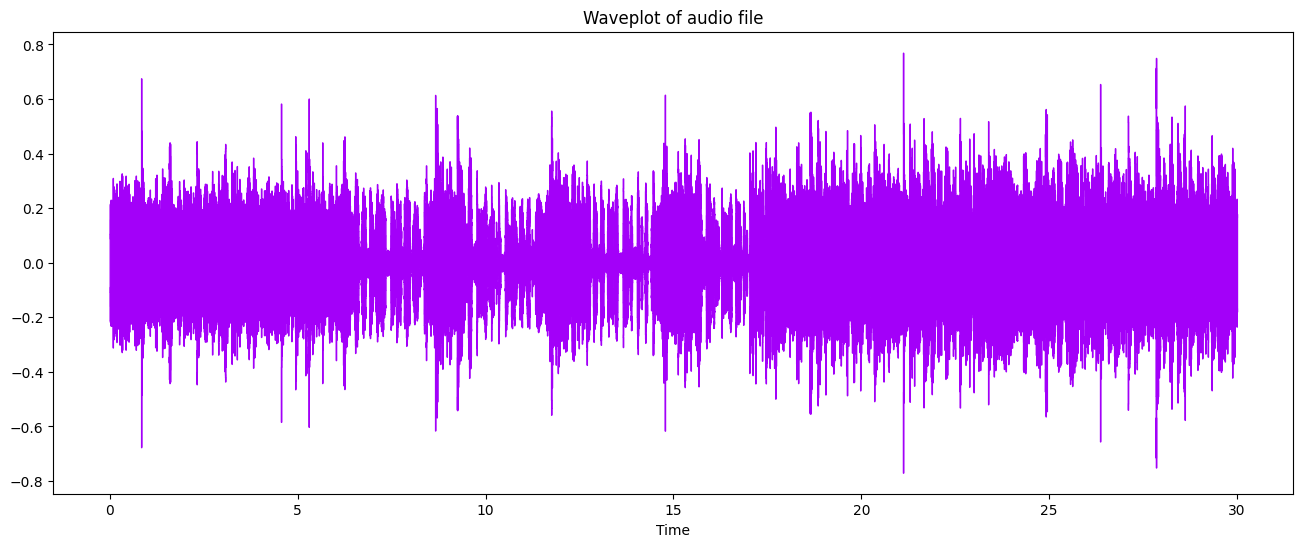

In [13]:
plt.figure(figsize=(16, 6))
librosa.display.waveshow(y, sr=sr, color="#A300F9")
plt.title("Waveplot of audio file");

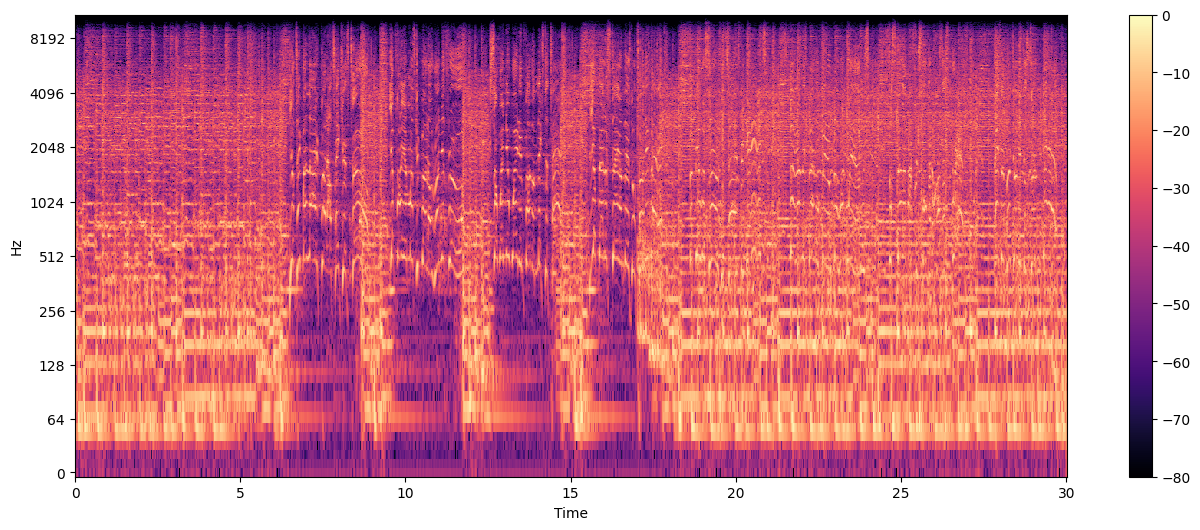

In [14]:
n_fft = 2048
hop_length = 512

audio_file, _ = librosa.effects.trim(y)
D = np.abs(librosa.stft(audio_file, n_fft = n_fft, hop_length = hop_length))

DB = librosa.amplitude_to_db(D, ref = np.max)

plt.figure(figsize = (16, 6))
librosa.display.specshow(DB, sr = sr, hop_length = hop_length, x_axis = 'time', y_axis = 'log')
plt.colorbar();

### Potential ways to extract features:
`tempo, _ = librosa.beat.beat_track(y=y, sr=sr)` for tempo of a track. <br>
`pitches, magnitudes = librosa.piptrack(y=y, sr=sr)` tracking the fundamental frequency over time. <br>
`harmonic, percussive = librosa.effects.hpss(y)` to separate the audio into harmonic and percussive parts. <br>
`spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)` measures the difference between the peaks and valleys in a audio. <br>